In [ ]:
!pip install tokenizers
!pip install torchdata

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import math

from typing import Tuple
from torch import Tensor
from torchtext.datasets import Multi30k
from torch.utils.data import DataLoader
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.processors import TemplateProcessing
from copy import deepcopy

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

In [4]:
SRC_LANGUAGE = 'de'
TGT_LANGUAGE = 'en'

train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))

f = open("parallelcorpus.txt", "a")

for i in train_iter:
  for x in [x.rstrip("\n") for x in i]:
    f.write(x)
    f.write(' ')

f.close()

In [5]:
MAX_LEN = 64
VOCAB_SIZE = 32768
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
BATCH_SIZE = 32

tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
trainer = BpeTrainer(vocab_size=VOCAB_SIZE, special_tokens=["[UNK]", "[PAD]", "[BOS]", "[EOS]"])
tokenizer.pre_tokenizer = Whitespace()
tokenizer.train(['parallelcorpus.txt'], trainer)

tokenizer.enable_padding(pad_id=1, length=MAX_LEN)
tokenizer.post_processor = TemplateProcessing(
    single="[BOS] $A [EOS]",
    special_tokens=[
        ("[BOS]", tokenizer.token_to_id("[BOS]")),
        ("[EOS]", tokenizer.token_to_id("[EOS]")),
    ],
)

def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_enc = tokenizer.encode(src_sample.rstrip("\n"))
        src_batch.append(torch.tensor(src_enc.ids))

        tgt_enc = tokenizer.encode(tgt_sample.rstrip("\n"))
        tgt_batch.append(torch.tensor(tgt_enc.ids))
    return torch.stack(src_batch), torch.stack(tgt_batch)

In [6]:
test_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn, drop_last=True)
test_dataloader = DataLoader(test_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn, drop_last=True)

In [7]:
class Embedding(nn.Module):
    def __init__(self, vocab_size=32678, d_model=512, pad_mask=1):
        super(Embedding, self).__init__()
        self.d_model = d_model
        self.emb = nn.Embedding(num_embeddings=vocab_size, embedding_dim=d_model, padding_idx=pad_mask)

    def forward(self, x):
        x = x.to(device)
        return self.emb(x) * math.sqrt(self.d_model)

In [8]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model=512, d_ff=2048, d_h=8, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.d_model = d_model
        self.d_h = d_h
        self.d_ff = d_ff
        self.d_k = self.d_v = int(d_model / d_h)
        self.dropout = nn.Dropout(dropout)
        self.Linear = nn.Linear(d_model, d_model)
        self.normalize1 = nn.LayerNorm(d_model)
        self.normalize2 = nn.LayerNorm(d_model)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model)
        )
        self.linears = nn.ModuleList([nn.Linear(d_model, self.d_k) for _ in range(d_h*3)])

    def forward(self, x):
        multi_head = []
        for i in range(self.d_h):
            query = self.linears[3*i](x)
            key = self.linears[3*i + 1](x)
            value = self.linears[3*i + 2](x)
            scaledDotProd = (query @ key.transpose(-1, -2)) / math.sqrt(self.d_k)
            soft = F.softmax(scaledDotProd, dim=-1)
            soft = self.dropout(soft)
            attn =  soft @ value
            multi_head.append(attn)
        selfAttn = self.Linear(torch.cat((multi_head), -1))
        addNorm = self.normalize1(x + selfAttn)
        encoderOutput = self.normalize2(x + self.feed_forward(addNorm))
        return encoderOutput

In [9]:
class EncoderStack(nn.Module):
    def __init__(self, d_model=512, d_ff=2048, d_h=8, dropout=0.1, N=6):
        super(EncoderStack, self).__init__()
        self.encoders = nn.ModuleList([EncoderLayer(d_model, d_ff, d_h, dropout) for _ in range(N)]) # Stacking Encoder Layer N Times

    def forward(self, x):
        for encoder in self.encoders:
            x = encoder(x)
        return x

In [10]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model=512, d_ff=2048, d_h=8, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.d_model = d_model
        self.d_h = d_h
        self.d_k = self.d_v = int(self.d_model / self.d_h)
        self.linears = nn.ModuleList([nn.Linear(d_model, self.d_k) for _ in range(d_h*3)])
        self.firstLinear = nn.Linear(d_h * self.d_v, d_model)
        self.secondLinear = nn.Linear(d_h * self.d_model, d_model)
        self.normalize1 = nn.LayerNorm(d_model)
        self.normalize2 = nn.LayerNorm(d_model)
        self.normalize3 = nn.LayerNorm(d_model)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model)
        )
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, y, y_mask=None):
        multi_head1 = []
        multi_head2 = []

        # FIRST ATTENTION LAYER
        ''' Same as encoder, but here we have tgt(target) as the decoder's input '''
        for i in range(self.d_h):
            query = self.linears[3*i](y)
            key = self.linears[3*i+1](y)
            value = self.linears[3*i+2](y)
            scaledDotProd = (query @ key.transpose(-1, -2)) / math.sqrt(self.d_k)
            if y_mask is not None:
                scaledDotProd = scaledDotProd.masked_fill(y_mask==0, float('-inf'))
            soft = F.softmax(scaledDotProd, dim=-1)
            soft = self.dropout1(soft)
            attn =  soft @ value
            multi_head1.append(attn)
        selfAttn = self.firstLinear(torch.cat((multi_head1), dim=-1))
        addNorm1 = self.normalize1(y + selfAttn)

        # SECOND ATTENTION LAYER
        ''' Attention layer, instead of V and K matrices, we use the output of the encoder '''
        for i in range(self.d_h):
            scaledDotProd = addNorm1 @ x.transpose(-1, -2) / math.sqrt(self.d_k)
            soft = F.softmax(scaledDotProd, dim=-1)
            soft = self.dropout2(soft)
            attn = soft @ x
            multi_head2.append(attn)
        crossAttn = self.secondLinear(torch.cat((multi_head2), dim=-1))
        addNorm2 = self.normalize2(y + crossAttn)
        decoderOutput = self.normalize3(y + self.feed_forward(addNorm2))
        return decoderOutput

In [11]:
class DecoderStack(nn.Module):
    def __init__(self, d_model=512, d_ff=2048, d_h=8, dropout=0.1, N=6):
        super(DecoderStack, self).__init__()
        self.decoders = nn.ModuleList([DecoderLayer(d_model, d_ff, d_h, dropout) for _ in range(N)]) # Stacking Decoder Layer N Times

    def forward(self, x, y, y_mask=None):
        for decoder in self.decoders:
            y = decoder(x, y, y_mask)
        return y

In [12]:
class Mask(nn.Module):
    def __init__(self):
        super(Mask, self).__init__()
    
    def forward(self, batch_size, seq_len1, seq_len2):
        mask = torch.tril(torch.ones(batch_size, seq_len1, seq_len2)).to(device)
        return mask

In [13]:
class Positional_Encoding(nn.Module):
    def __init__(self, d_model=512, n=10000):
        super(Positional_Encoding, self).__init__()
        self.d_model = d_model
        self.n = n
    def forward(self, seq_len):
        P = torch.zeros(seq_len, self.d_model)
        for k in range(seq_len):
            for i in range(self.d_model // 2):
                denominator = math.pow(self.n, 2*i/self.d_model)
                P[k, 2*i] = math.sin(k/denominator)
                P[k, 2*i+1] = math.cos(k/denominator)
        P = P.to(device)
        return P

In [16]:
class ModelOutput(nn.Module):
    def __init__(self, d_model, vocab_size):
        super(ModelOutput, self).__init__()
        self.linear = nn.Linear(d_model, vocab_size)
    def forward(self, x):
        return self.linear(x)

In [18]:
class Transformer(nn.Module):
    def __init__(self, d_model=512, d_h = 8, d_ff=2048, vocab_size=32768, dropout=0.1, num_coder_layers=6):
        super(Transformer, self).__init__()
        self.d_model = d_model
        self.d_h = d_h
        self.linear = nn.Linear(d_model, vocab_size)
        self.generate = ModelOutput(d_model, vocab_size)
        self.dropoutEnc = nn.Dropout(dropout)
        self.dropoutDec = nn.Dropout(dropout)
        self.embed = Embedding(vocab_size, d_model, pad_mask=1)
        self.positional = Positional_Encoding(self.d_model, 10000)
        self.masking = Mask()
        self.encoderStack = EncoderStack(d_model, d_ff, d_h, dropout, num_coder_layers)
        self.decoderStack = DecoderStack(d_model, d_ff, d_h, dropout, num_coder_layers)

    def forward(self, x: Tensor, y: Tensor):
        assert x.shape[0] == y.shape[0]
        batch_dim = x.shape[0]
        assert x.shape[1] == y.shape[1]
        seq_len = x.shape[1]

        y_mask = self.masking(batch_dim, seq_len, seq_len)

        x, y = self.embed(x), self.embed(y)

        pos_encoding = self.positional(seq_len)

        x = pos_encoding + x
        y = pos_encoding + y

        x, y = self.dropoutEnc(x), self.dropoutDec(y)

        encoderOutput = self.encoderStack(x)

        decoderOutput = self.decoderStack(encoderOutput, y, y_mask)

        logits = self.generate(decoderOutput)

        return logits

In [19]:
model = Transformer(d_model=512, d_h=8, d_ff=2048, vocab_size=VOCAB_SIZE, dropout=0.3, num_coder_layers=3).to(device)

In [20]:
def train(model: nn.Module, train_data: DataLoader, test_data: DataLoader, learning_rate: int, padding_idx: int, epoch_num: int):

    optimizer = optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss(ignore_index=1)

    train_loss = []

    for epoch in range(0, epoch_num):

        print("#"*67)
        print(f'{"#"*20}Training begins for epoc {epoch:>2}{"#"*20}')
        print("#"*67)
        loss_arr=[]
        total_loss = 0
        for i, (src, tgt) in enumerate(train_data):

            src, tgt = src.to(device), tgt.to(device)
            optimizer.zero_grad()
            probs = model(src, tgt).permute(0, 2, 1)
            loss = criterion(probs, tgt)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()

            if i%100 == 0 and i != 0:
                loss_per_batch = total_loss / 100
                print(f'Loss per batch is: {loss_per_batch}')
                loss_arr.append(loss_per_batch)
                train_loss.append(loss_per_batch)
                total_loss = 0
        
        print(f'Training is complete for epoch {epoch:>2}, average training loss for epoch {epoch:>2}: {np.average(loss_arr):>5.3f}')
        print("-"*67)
    print("Loss graph: ")
    plt.plot(train_loss, color='blue')
    plt.title("Loss Graph")
    plt.xlabel("Batch")
    plt.ylabel("Loss per Batch")
    plt.show()

###################################################################
####################Training begins for epoc  0####################
###################################################################
Loss per batch is: 2.3146367114782334
Loss per batch is: 0.7558378687500954
Loss per batch is: 0.5250715824961663
Loss per batch is: 0.39204117462038995
Loss per batch is: 0.31017629101872446
Loss per batch is: 0.27458895564079283
Loss per batch is: 0.22657060079276561
Loss per batch is: 0.20447475016117095
Loss per batch is: 0.20920431099832057
Training is complete for epoch  0, average training loss for epoch  0: 0.579
-------------------------------------------------------------------
###################################################################
####################Training begins for epoc  1####################
###################################################################
Loss per batch is: 0.08189887491753325
Loss per batch is: 0.05732614059234038
Loss per batch is: 0.

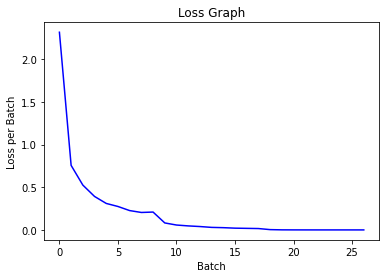

In [21]:
train(model, train_dataloader, test_dataloader, learning_rate=0.001, padding_idx=PAD_IDX, epoch_num=3)

In [23]:
src, tgt = next(iter(test_dataloader))
print(src.shape)
print(tgt.shape)

torch.Size([32, 64])
torch.Size([32, 64])


In [24]:
logits = model(src, tgt)
pred = torch.argmax(logits, dim=2)

In [25]:
for example in range(10):
    print(f"Example no {example}: ")
    pad_count = (tgt[example] == PAD_IDX).data.sum().item()
    sentence_len = tgt.shape[1] - pad_count
    print("#"*80)
    print("#German text: ", tokenizer.decode(src[example].cpu().numpy().squeeze()))
    print("#"*80)
    print("#English translation: ", tokenizer.decode(tgt[example].cpu().numpy().squeeze()))
    print("#"*80)
    print("#Model translation: ", tokenizer.decode(pred[example][:sentence_len].cpu().numpy().squeeze()))
    print("#"*80)
    print("\n")

Example no 0: 
################################################################################
#German text:  Eine Gruppe von Männern lädt Baumwolle auf einen Lastwagen
################################################################################
#English translation:  A group of men are loading cotton onto a truck
################################################################################
#Model translation:  A group of men are loading cotton onto a truck
################################################################################


Example no 1: 
################################################################################
#German text:  Ein Mann schläft in einem grünen Raum auf einem Sofa .
################################################################################
#English translation:  A man sleeping in a green room on a couch .
################################################################################
#Model translation:  A man sleeping in a green room 

In [ ]:
def translate(model: nn.Module, source: Tensor, start_token: int, stop_token: int, seq_len: int):
    src_pos_enc = model.positional(source.shape[1]).unsqueeze(0)

    src_embedding = model.embed(source)

    encoderInput = src_embedding + src_pos_enc

    encoderOutput = model.encoderStack(encoderInput)

    sequence = torch.tensor([[start_token]], dtype=torch.int32)

    for _ in range(30):
        embedded_sequence = model.embed(sequence)

        seq_pos_enc = model.positional(sequence.shape[1]).unsqueeze(0)

        decoderInput = embedded_sequence + seq_pos_enc

        decoderInputMask = model.masking(sequence.shape[0], sequence.shape[1], sequence.shape[1])

        decoderOutput = model.decoderStack(encoderOutput, decoderInput)

        logits = decoderOutput[:, -1, :]

        logits = model.generate(logits)

        generated_word_id = torch.argmax(logits, dim=-1)
        generated_word_tensor = torch.tensor([[generated_word_id.item()]], dtype=torch.int32)

        sequence = torch.cat((sequence, generated_word_tensor), dim=1)

        if generated_word_id == stop_token:
            break
        
    print(sequence)

    translation_ids = sequence.cpu().numpy()

    translation = tokenizer.decode(translation_ids.squeeze())
    return translation

translation = translate(model=model, source=src, start_token=2, stop_token=EOS_IDX, seq_len=MAX_LEN)
print(translation)